In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [386]:
data_train = pd.read_csv("cbr_banks101_1481.txt",sep=';',header = None) 
data_train = data_train[[1,2,14]] 
data_train = data_train.rename(columns={1: "Date", 2:"Id", 14: "Deposit_sum"}) 
data_train["Date"] = pd.to_datetime(data_train['Date'])

In [387]:
#Для анализа были выбраны данные по депозитам в соответствии со статьями 
#из раздела 423 "Депозиты и прочие привлеченные средства физических лиц" 
#плана счетов бухгалтерского учета в кредитных организациях 

data_train = data_train[data_train["Id"].str.contains(r'^423[0-9]{2}$')] 
data_train = data_train.sort_index(ascending = False)

In [388]:
data_train.head()

,Date,Id,Deposit_sum
75564,2007-02-01,42307,2.127256e+08
75563,2007-02-01,42306,1.378279e+09
75562,2007-02-01,42305,1.637487e+08
75561,2007-02-01,42304,6.764188e+07
75560,2007-02-01,42303,2.180846e+07


In [389]:
data_train.dtypes

Date           datetime64[ns]
Id                     object
Deposit_sum           float64
dtype: object

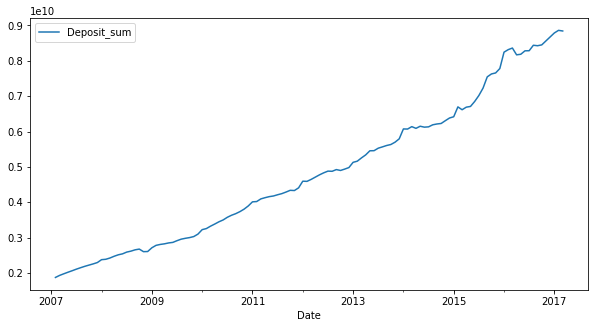

In [401]:
s = data_train.groupby(data_train['Date'].dt.to_period('M')).sum()
s.plot(kind = 'line')
plt.gcf().set_size_inches(10, 5)

In [391]:
s.head()

,Deposit_sum
Date,
2007-02,1.874912e+09
2007-03,1.932859e+09
2007-04,1.978653e+09
2007-05,2.022986e+09
2007-06,2.065113e+09


In [392]:
from fbprophet import Prophet

In [393]:
#Для реализации fit через fbprophet необходимы столбцы 'ds','y', даты в виде PeriodIndex не подойдут. 
#Добавим дополнительный столбец Date, затем переименуем столбцы

s.index = s.index.to_timestamp()
s['Date'] = pd.DatetimeIndex(s.index)
s = s[['Date','Deposit_sum']]

In [394]:
df = s.rename(columns={'Date': 'ds',
                        'Deposit_sum': 'y'})

In [395]:
my_model = Prophet()
my_model.fit(df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [396]:
future_dates = my_model.make_future_dataframe(periods=10, freq='MS')
future_dates[120:130]

,ds
120,2017-04-01
121,2017-05-01
122,2017-06-01
123,2017-07-01
124,2017-08-01
125,2017-09-01
126,2017-10-01
127,2017-11-01
128,2017-12-01
129,2018-01-01


In [397]:
forecast = my_model.predict(future_dates)

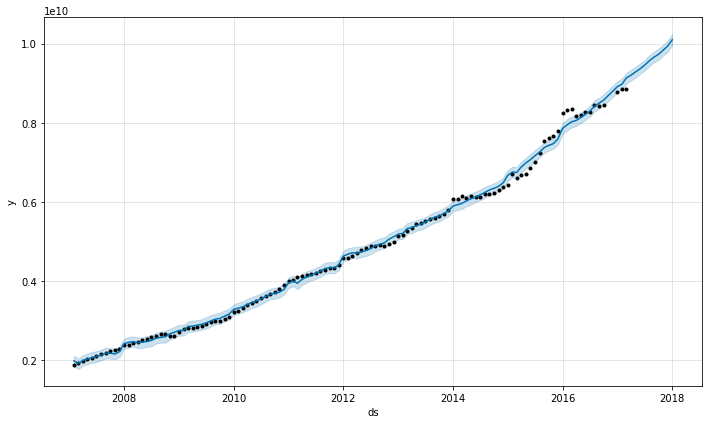

In [404]:
p1 = my_model.plot(forecast, uncertainty=True)

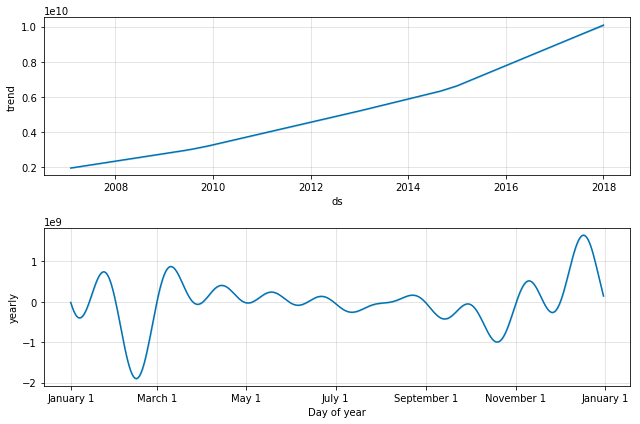

In [380]:
p2 = my_model.plot_components(forecast)

Text(0, 0.5, 'Forecast')

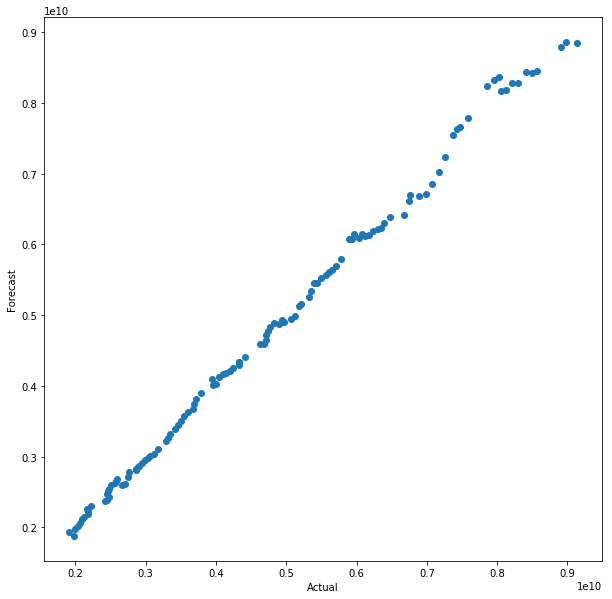

In [383]:
plt.figure(figsize = (10,10))
plt.scatter(forecast[0:120].yhat,s.Deposit_sum.values)
plt.xlabel('Actual')
plt.ylabel('Forecast')

In [400]:
preds = forecast[120:130].yhat
preds

120    9.201366e+09
121    9.283501e+09
122    9.363779e+09
123    9.455695e+09
124    9.564422e+09
125    9.657672e+09
126    9.726960e+09
127    9.830947e+09
128    9.933727e+09
129    1.009566e+10
Name: yhat, dtype: float64